In [ ]:
# data 확인!
!ls -al

total 16
drwxr-xr-x 1 root root 4096 Jan  7 14:33 .
drwxr-xr-x 1 root root 4096 Jan 21 07:47 ..
drwxr-xr-x 4 root root 4096 Jan  7 14:33 .config
drwxr-xr-x 1 root root 4096 Jan  7 14:33 sample_data


In [ ]:
# kaggle. json key file 업로드
from google.colab import files
files.upload()

# path
# C:\Users\gksxo\Desktop\Folder\순천향대학교\GDSC\캐글 API 토큰

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maninblack","key":"8bb769c984f16315fdf92cab4351f4c8"}'}

In [ ]:
# 캐글 데이터셋 불러오기전 세팅
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ # json file 이동
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         78           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        115           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        875           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        176           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1889           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13675            True  
house-pr

In [ ]:
# 세팅 확인
!ls ~/.kaggle

kaggle.json


In [ ]:
# 데이터 불러오기
!kaggle datasets download -d alessiocorrado99/animals10

 97% 566M/586M [00:06<00:00, 71.8MB/s]
100% 586M/586M [00:06<00:00, 90.8MB/s]


In [ ]:
# 데이터 불러오기전 확인
!ls -al

total 599720
drwxr-xr-x 1 root root      4096 Jan 21 08:02 .
drwxr-xr-x 1 root root      4096 Jan 21 07:51 ..
-rw-r--r-- 1 root root 614087302 Jan 21 08:02 animals10.zip
drwxr-xr-x 4 root root      4096 Jan  7 14:33 .config
-rw-r--r-- 1 root root        66 Jan 21 07:53 kaggle.json
drwxr-xr-x 1 root root      4096 Jan  7 14:33 sample_data


In [ ]:
!unzip animals10.zip

In [ ]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# version
- numpy: 1.21.1
- pandas: 1.35
- cv2: 4.0.1
- matplotlib: 3.5.0
- tqdm: 4.62.3
- sklearn: 1.0.2
- keras: 2.6.0
- tensorflow: 2.8.0

In [ ]:
# 폴더 이름
IMG_FOLDER_PATH = './raw-img/' 
foldernames = os.listdir(IMG_FOLDER_PATH)
categories = []
files = []
i = 0

# 이미지 카테고리 추출 및
# 이미지 파일 추출
for k, folder in enumerate(foldernames):
    filenames = os.listdir(IMG_FOLDER_PATH + folder);
    for file in filenames:
        files.append(IMG_FOLDER_PATH + folder + "/" + file)
        categories.append(k)

# 데이터 프레임 생성
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

# 훈련 데이터 프레임 생성
train_df = pd.DataFrame(columns=['filename', 'category'])

# 카테고리별 데이터 500개씩 추출
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

# 데이터 확인
train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

# 총 row : 5_000

,filename,category
0,./raw-img/pecora/OIP-jhqZKyUXtnx539TSBBK7qQHaE...,0
1,./raw-img/pecora/OIP-DnSV_9VzsAn65-ImWShrVAHaD...,0
2,./raw-img/pecora/OIP-Q-z_4a8001pkpcxQcqvo0QHaC...,0
3,./raw-img/pecora/ea36b30e2cfd093ed1584d05fb1d4...,0
4,./raw-img/pecora/OIP-mb0aa7L5cmkmxpwWtKjjzQHaE...,0
...,...,...
4995,./raw-img/cavallo/OIP-dUUmM7yVE3vhAxInRvhlaQHa...,9
4996,./raw-img/cavallo/OIP-xjaXHdCZGkQbTuQdxhb6TwHa...,9
4997,./raw-img/cavallo/OIP-woMmrIUCWOoIzguTWRhimAHa...,9
4998,./raw-img/cavallo/OIP-Vxvl69Gn7I7IK5CsHNJk_QHa...,9


In [ ]:
x = train_df['filename']
y = train_df['category']

# 데이터 섞기
x, y = shuffle(x, y, random_state=8)
print(x, y)

2735    ./raw-img/gallina/OIP-f4vsXOtjtM9v81Y2471-zwHa...
4027    ./raw-img/farfalla/OIP-iS4JHnHH1EsU1KsgmwBxQAH...
1648                             ./raw-img/gatto/335.jpeg
1746                             ./raw-img/gatto/263.jpeg
4640    ./raw-img/cavallo/OIP-0jYzXVBCAWowQfyLEiWzSAHa...
                              ...                        
2181    ./raw-img/cane/OIP-OeKgcRs4WciKEHD0g3DYPQHaJ4....
2409    ./raw-img/cane/OIP-VpuyjBiDpBZhkEs5IN4XRgHaKI....
2033    ./raw-img/cane/OIP-XOMNh0eEAbPFp-T45RacsAHaHa....
1364    ./raw-img/scoiattolo/OIP-4pFQmUXBpNzHL0wdFE4La...
4547    ./raw-img/cavallo/OIP-6592kOMMgBXKuOZF1X6ftQHa...
Name: filename, Length: 5000, dtype: object 2735    5
4027    8
1648    3
1746    3
4640    9
       ..
2181    4
2409    4
2033    4
1364    2
4547    9
Name: category, Length: 5000, dtype: object


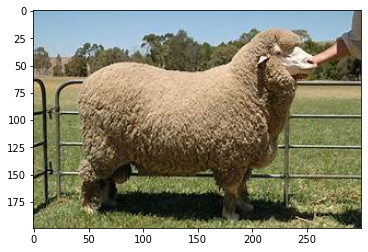

(199, 300, 3)
tile_size: (256, 169)


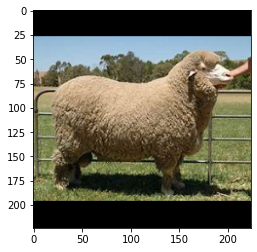

(224, 224, 3)


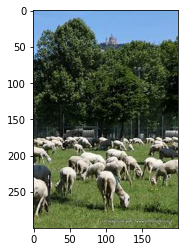

(300, 200, 3)
tile_size: (170, 256)


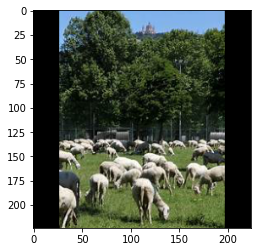

(224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 이미지 읽는 라이브러리

# 이미지 전처리 확인하기

# ------------------------------------------------------------------- #
def centering_image(img):
    size = [256,256]
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized
# ------------------------------------------------------------------- #

# 가로 이미지 > img.shape[1] 더큼
test_img = './raw-img/pecora/OIP-jhqZKyUXtnx539TSBBK7qQHaE6.jpeg'
img = mpimg.imread(test_img)
plt.imshow(img)
plt.show()
print(img.shape)

# 가로 이미지 변형 < 정사각형 비율로 변경 > 224 x 224
tile_size = (256, int(img.shape[0]*256/img.shape[1]))
print("tile_size:", tile_size)
img = centering_image(cv2.resize(img, dsize=tile_size))
img = img[16:240, 16:240]
plt.imshow(img)
plt.show()
print(img.shape)

# 세로 이미지  > img.shape[0] 더큼
test_img = "./raw-img/pecora/OIP-gbxNqYWOnt5R3tvyulJQuwHaLH.jpeg"
img = mpimg.imread(test_img)
plt.imshow(img)
plt.show()
print(img.shape)

# 세로 이미지 변형 < 정사각형 비율로 변경 > 224 x 224
tile_size = (int(img.shape[1]*256/img.shape[0]),256)
print("tile_size:", tile_size)
img = centering_image(cv2.resize(img, dsize=tile_size))
img = img[16:240, 16:240]
plt.imshow(img)
plt.show()
print(img.shape)

In [ ]:
# 모든 이미지에 적용
images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path) # 이미지 읽기
        # BGR 사진을 RGB 사진으로 변환하기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize : 크기 조정
        if(img.shape[0] > img.shape[1]): # 가로 / 세로 이미지 판별
            # 가로 이미지
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            # 세로 이미지
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5000 [00:00<?, ?it/s]

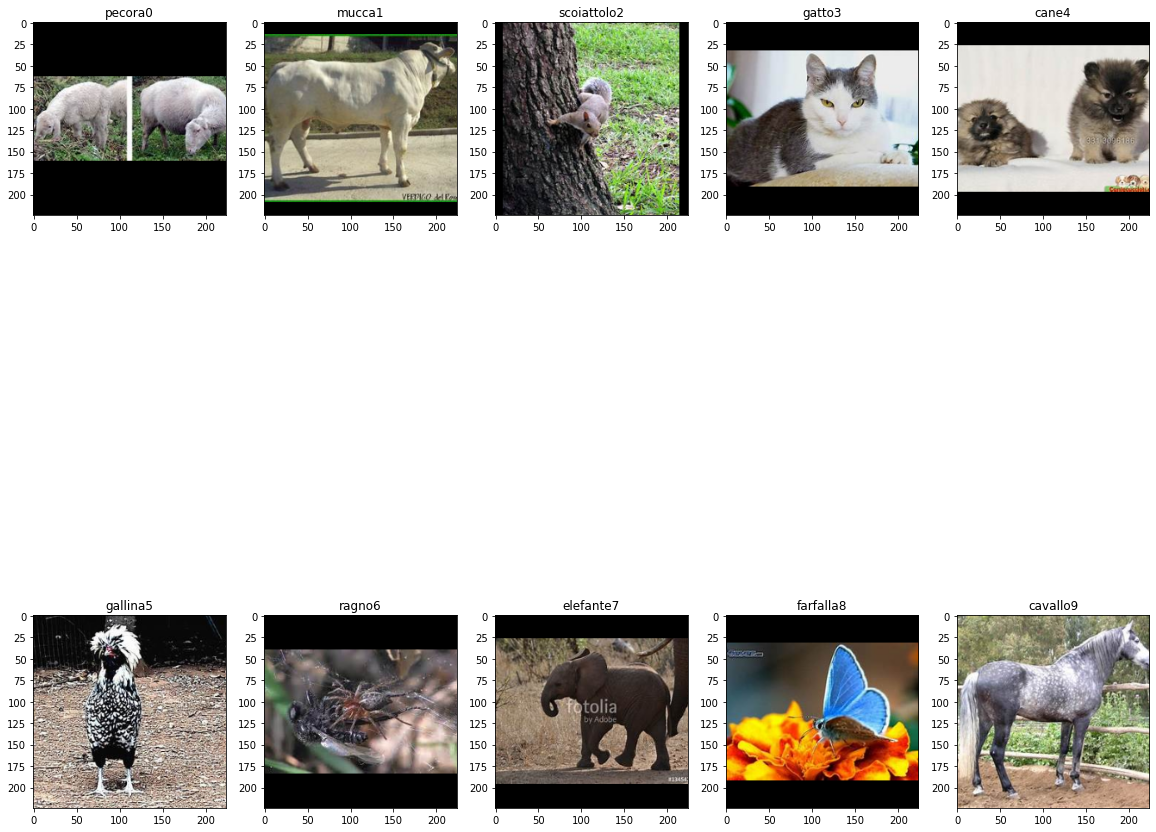

In [ ]:
# 시각화 레이아웃 설정
rows, cols = 2, 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

for i in range(10):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [ ]:
data_num = len(y) # 데이터 row 수
random_index = np.random.permutation(data_num) # 인덱스 섞기

x_shuffle = []
y_shuffle = []
# 데이터 섞기 적용
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

x = np.array(x_shuffle) # 이미지 데이터
y = np.array(y_shuffle) # 라벨
val_split_num = int(round(0.2*len(y))) # 데이터 비율 0.2

# train, test 데이터 나누기
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

# 데이터 확인
print('x_test', x_train.shape) # row, height, width, depth
print('y_train', y_train.shape) # row,
print('x_test', x_test.shape) # row, height, width, depth
print('y_test', y_test.shape) # row,

# label 이진 분류 0, 1로 만든다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 실수형으로 변경 후 255 나눈다. > 정규화
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# input 이미지 데이텨 형태
img_rows, img_cols, img_channel = 224, 224, 3

# 동물이름 영문으로 추출
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')
        
print(name_animal)

x_test (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)
['sheep', 'cow', 'squirrel', 'cat', 'dog', 'chicken', 'spider', 'elephant', 'butterfly', 'horse']


In [ ]:
 # 모델 생성

# CNN 파생 알고리즘
# VGGNet은 옥스포드 대학의 연구팀 VGG에 의해 개발된 모델
# VGGNet은 16개 또는 19개의 층으로 구성된 모델을 의미한다(VGG16, VGG19로 불림)


base_model = applications.vgg16.VGG16(
    weights='imagenet',
    # one of None (random initialization), 
    # 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

    include_top=False, 
    # whether to include the 3 fully-connected layers at the top of the network.
    # 네트워크 맨 위에 완전히 연결된 세 개의 레이어를 포함할지 여부를 지정합니다.

    input_shape=(
        img_rows, 
        img_cols, 
        img_channel
        )
    )

# 모델 Flatten 과정
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax')) # 결과 10

# 모델 생성
model = Model(
    inputs=base_model.input,
    outputs=add_model(base_model.output)
    )

# 다른경로 충돌 떄문에 직접 경로 import
from tensorflow.keras.optimizers import SGD

model.compile(loss='binary_crossentropy',
              # 이진 분류?
              optimizer=SGD(lr=1e-4, momentum=0.9),
              # optimizers.SGD : Gradient descent (with momentum) optimizer.
              # 경사 강하
              metrics=['accuracy'])

model.summary() # 모델 확인하기

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
batch_size = 32
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, # 30도
        # 정수. 무작위 회전의 각도 범위입니다.
        width_shift_range=0.1,
        # 좌우이동 10%
        height_shift_range=0.1, 
        # 상하이동 10%
        horizontal_flip=True
        # 좌우반전 True
        )

# data 이미지 생성
train_datagen.fit(x_train)

history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size), # 훈련 데이터
    steps_per_epoch=x_train.shape[0] // batch_size, # 매 epoch 마다 일정 비율로 나눠서 메모리
    epochs=epochs, # 학습 횟수
    validation_data=(x_test, y_test), # 시험 데이터
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')] # 콜백함수
)

# 학습 완료! 2022-01-22 ??

2.7.0
